In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Mounted at /content/gdrive
Cloning into 'dl_basics'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 373 (delta 41), reused 48 (delta 22), pack-reused 285
Receiving objects: 100% (373/373), 16.71 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (174/174), done.
Found GPU: Tesla T4.


In [2]:
import models
import utils

In [3]:
(x_mnist_tr, y_mnist_tr), (x_mnist_te, y_mnist_te) = tf.keras.datasets.mnist.load_data()
#x_mnist_tr = np.expand_dims(x_mnist_tr.astype(np.float32) / 255.0, -1)
#x_mnist_te = np.expand_dims(x_mnist_te.astype(np.float32)  / 255.0, -1)
x_mnist_tr = (x_mnist_tr.astype(np.float32) / 255.0).reshape(-1, 28*28)
x_mnist_te = (x_mnist_te.astype(np.float32) / 255.0).reshape(-1, 28*28)

x_train = x_mnist_tr[:50000]
y_train = y_mnist_tr[:50000]
x_val   = x_mnist_tr[50000:]
y_val   = y_mnist_tr[50000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

11490434/11490434 [==============================] - 2s 0us/step


((50000, 784), (50000,), (10000, 784), (10000,))

In [4]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.regularizers import L2
from models.transformers import transformer_block

def mlp_conv2d(dummy):

    inp = Input(shape=(28*28,), name="input")
    x = tf.reshape(inp, (-1,28,28,1))
    x = Conv2D(64, 5, strides=2, use_bias=False)(x)
    x = Conv2D(64, 5, strides=2, use_bias=False)(x)
    x = Conv2D(10, 4, strides=1, use_bias=False)(x)
    x = Flatten()(x)
    out = x
    
    model = Model(inp, out, name="mlp_conv2d")
    return model

In [14]:
# init new run
P = { "training_data" : "mnist50-10" }

'''
P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (28*28,),
    "layer_units" : [ 10 ],
    "activations" : [ "linear" ],
    "use_bias" : False,
    "regularizer" : None, #"L2(0.01)"
}

P["model_name"] = "mlp_residual"
P["model_build_params"] = {
    "input_shape" : (28*28,),
    "layer_units" : [ 128, 128, 10 ],
    "activations" : [ "linear", "relu", "linear" ],
    "use_bias" : False,
    "regularizer" : "L2(0.01)"
}
'''

P["model_name"] = "mlp_conv2d"
P["model_build_params"] = {
    "dummy" : 1,
}

P["random_seed"] = 42
utils.tf_keras_random_seed(P["random_seed"])

#model = eval("models." + P["model_name"])(**P["model_build_params"])
model = eval(P["model_name"])(**P["model_build_params"])
model.summary()

P["loss"] = "SparseCategoricalCrossentropy(from_logits=True)"
P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
#P["optimizer"] = "SGD(1e-3, momentum=0.9)"
P["metrics"] = [ "accuracy" ]
model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
#weight_logger = utils.SaveWeightsPower2(LOG_DIR)

Model: "mlp_conv2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 12, 12, 64)        1600      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          102400    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 10)          10240     
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
Total params: 114,240
Trainable params: 114,240
Non-trai

In [22]:
NUM_EPOCHS = 128 * 6
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    initial_epoch = run.current_epoch,
    epochs = run.current_epoch + NUM_EPOCHS,
    batch_size = 1000,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
        weight_norm_logger,
        #weight_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

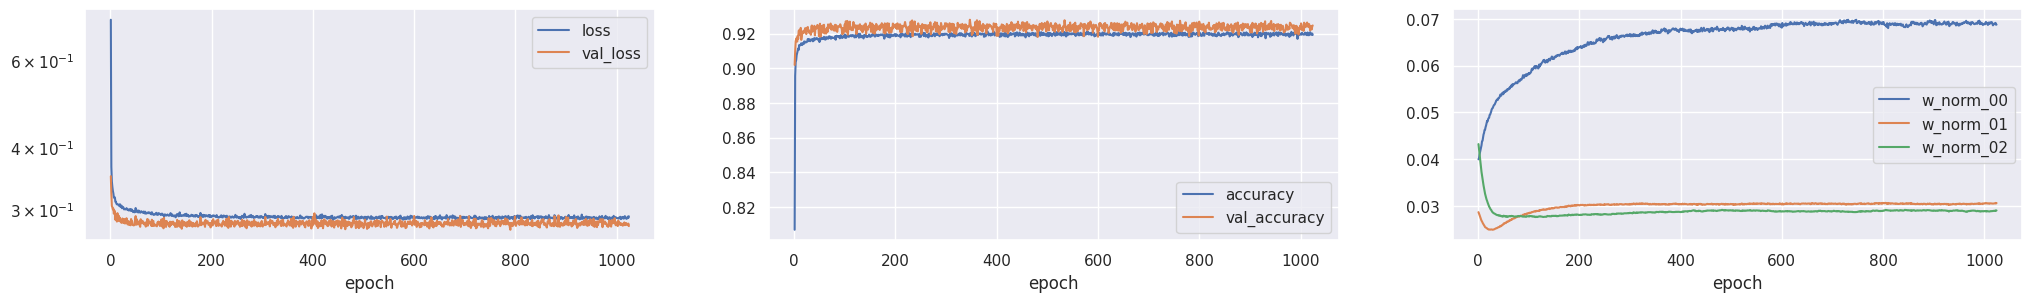

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(25,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [26]:
run.save_state(LOG_DIR, P, model)
weight_norm_logger.norms_to_csv(LOG_DIR)

In [18]:
def plot_matrix(m, ax, scale=1.0):
    mmax = np.max(np.abs(m)) / scale
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

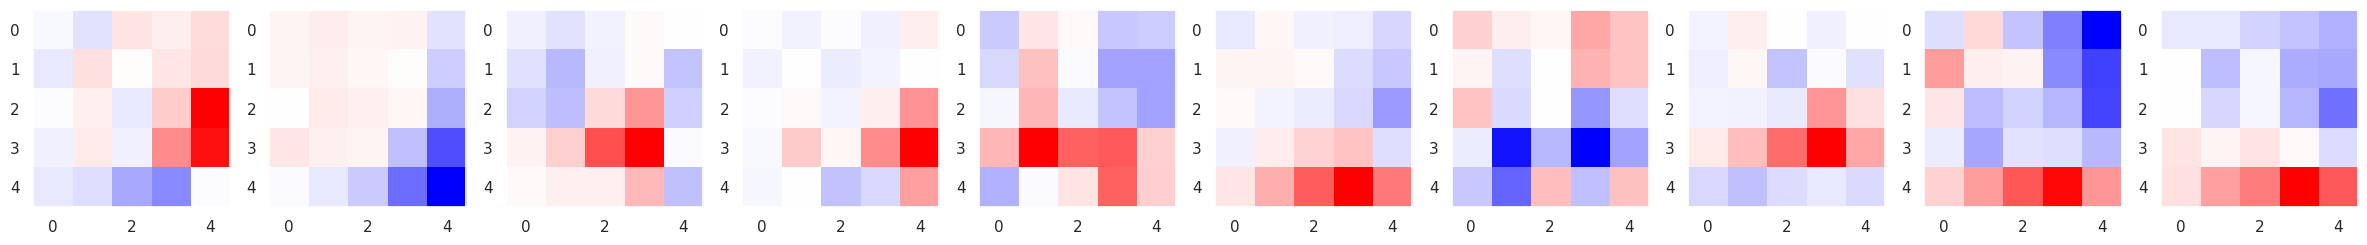

In [19]:
fig, axs = plt.subplots(1, 10, figsize=(30,5))

w = model.get_weights()[0]

for i in range(10):
    plot_matrix(w.reshape(5,5,-1)[:,:,i+0], axs[i], scale=1)